# Introduction to Machine Learning — 2024/2025 Unsupervised Learning

This assignment will demonstrate how a learning algorithm can distinguish between two distributions of points generated with different parameters, using no information on the target values.


## Exercise 1
Generate 2D points using a multivariate Gaussian distribution
1. Use the code in Fig. 1 to generate two sets, each with 500 points (reduce this number if necessary to obtain better visualizations or faster training runs),
2. Each dataset should have different centers, and sets should have a small overlap.
3. Add a column and fill it with 1 (one) for the first dataset and 2 (two) on the second, so that you can keep track of which distribution generated each point.
4. Join and shuffle the dataset.
5. The plot of the first two columns should be similar to the one presented in Fig. 2.
6. Write the dataset to a file. 

In [42]:
# import packages
import matplotlib . pyplot as plt 
import numpy as np
from numpy import genfromtxt
import random
import math

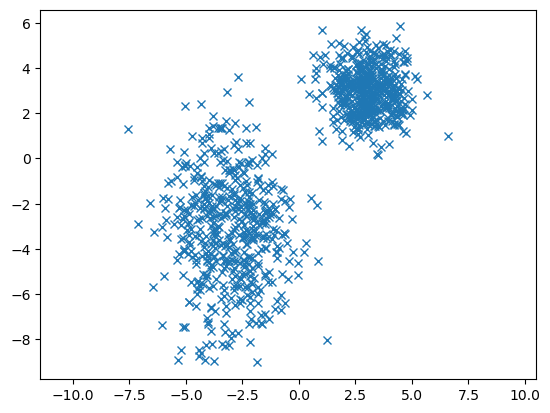

In [2]:
# generate data

mean= [3, 3]
cov = [[1, 0], [0, 1]]
a = np.random.multivariate_normal(mean, cov, 500).T

new_col_a = np.ones((1, a.shape[1]))
a = np.append(a, new_col_a, axis = 0)

mean= [-3, -3]
cov = [[2, 0], [0, 5]]
b = np.random.multivariate_normal(mean, cov, 500).T

new_col_b = np.full((1, b.shape[1]), 2)
b = np.append(b, new_col_b, axis = 0)

c = np.concatenate((a, b) , axis = 1) 
c=c.T
np.random.shuffle(c)
c=c.T

x = c[0] 
y=c[1]
labels=c[2]
plt.plot(x, y, "x") 
plt.axis("equal") 
plt .show()

# save and load data
np.savetxt("testData.csv", c, delimiter=",")
data = genfromtxt('testData.csv', delimiter=',')

### Exercise 1.1 Implement a simple version of K-Means

Start by choosing two random points in the dataset r1 and r2 and apply the following adaptation rule:

    for all x ∈ the dataset do
        if x is closer to r1 than to r2 then
            r1 ←(1−α)×r1 +α×x
        else if x is closer to r2 than to r1 then
            r2 ←(1−α)×r2 +α×x 
        end if
    end for




In [3]:
def getEuclideanDistance(trainData1Coordinate, trainData2Coordinate, testData1Coordinate, testData2Coordinate):
    distance = math.sqrt((trainData1Coordinate-testData1Coordinate)**2+(trainData2Coordinate-testData2Coordinate)**2)
    return(distance)

In [10]:
# define parameters
alpha = 0.00001

# choose random k indexes
# copy data for immutability and transpose to sample complete case
cTCopy = c.T
idexOfPoint1, indexOfPoint2= random.sample(range(len(cTCopy)), k=2)

# define the two k points following the andom indexes
r1 = cTCopy[idexOfPoint1][:2]
r2 = cTCopy[indexOfPoint2][:2]

# initialize two np.arrays to save clusters
cluster1 = []
cluster2 = []

# save all consecutive values of r1 and r2 for the first passage
allValuesOfR1 = []
allValuesOfR2 = []

# implement easy k-means version
for i in range(len(cTCopy)):
    # divide every point in coordinates and label
    coordinate = cTCopy[i][:2]
    trueClusterLabel = cTCopy[i][2]

    # get distance to both k
    distanceToR1 = getEuclideanDistance(r1[0],r1[1], coordinate[0], coordinate[1])
    distanceToR2 = getEuclideanDistance(r2[0],r2[1], coordinate[0], coordinate[1])

    

    # append to cluster of k to which point is closer, swiftly adjust k in position
    if distanceToR1 < distanceToR2:
        allValuesOfR1.append(r1)
        cluster1.append([*coordinate, trueClusterLabel])
        r1 = (1-alpha)*r1+alpha*coordinate
    else:
        allValuesOfR2.append(r2)
        cluster2.append([*coordinate, trueClusterLabel])
        r2 = (1-alpha)*r2+alpha*coordinate

# check length of final clusters to see whether all points have been assigned
print(len(cluster2))
print(len(cluster1))



385
615


### Exercise 1.2 
Repeat for 10 times a passage through all the elements of the dataset (i.e. 10 epochs) with α = 10E − 5 and save:

(i) the consecutive values of r1 and r2 for the first passage; 

(ii) the values of r1 and r2 at the end of each passage.

In [6]:
# (ii) the consecutive values of r1 and r2 for the first passage
allValuesOfR1
allValuesOfR2
print(len(allValuesOfR1)+len(allValuesOfR2))

1000


In [13]:
# (ii) the values of r1 and r2 at the end of each passage.

# define parameters
alpha = 0.00001

# choose random k indexes
# copy data for immutability and transpose to sample complete case
cTCopy = c.T
idexOfPoint1, indexOfPoint2= random.sample(range(len(cTCopy)), k=2)

# define the two k points following the random indexes
r1 = cTCopy[idexOfPoint1][:2]
r2 = cTCopy[indexOfPoint2][:2]

# initialize lists to store final r1 and r2 values
r1AfterClustering = []
r2AfterClustering = []

# repeat for 10 times:
for i in range(10):

    # implement easy k-means version
    for i in range(len(cTCopy)):
        # divide every point in coordinates and label
        coordinate = cTCopy[i][:2]
        trueClusterLabel = cTCopy[i][2]

        # get distance to both k
        distanceToR1 = getEuclideanDistance(r1[0],r1[1], coordinate[0], coordinate[1])
        distanceToR2 = getEuclideanDistance(r2[0],r2[1], coordinate[0], coordinate[1])

        # append to cluster of k to which point is closer, swiftly adjust k in position
        if distanceToR1 < distanceToR2:
            #cluster1.append([*coordinate, trueClusterLabel])
            r1 = (1-alpha)*r1+alpha*coordinate
        else:
            #cluster2.append([*coordinate, trueClusterLabel])
            r2 = (1-alpha)*r2+alpha*coordinate


    r1AfterClustering.append(r1)
    r2AfterClustering.append(r2)



### Exercise 1.3

Plot (i) and (ii) upon the dataset plot in different graphs. Change the value of α and the number of epochs to see the evolution of the representatives clearly. What do you conclude about the evolution of the two points in the different situations? Is there any relation between the final values of the representatives (r1 and r2) and the parameters used to generate the dataset?

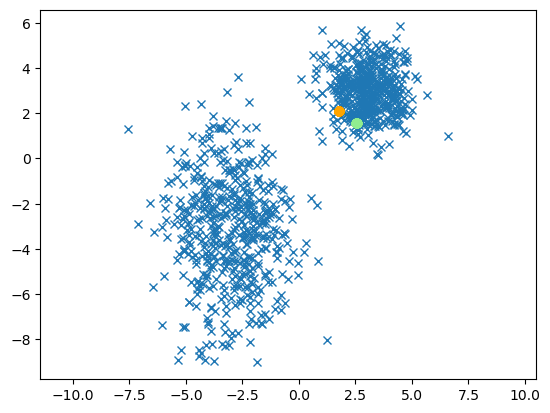

In [14]:
# plot (i) uppon the dataset

x = c[0] 
y=c[1]

xR1 = []
for r1 in allValuesOfR1:
    xR1.append(r1[0])

xR2 = []
for r2 in allValuesOfR2:
    xR2.append(r2[0])

yR1 = []
for r1 in allValuesOfR1:
    yR1.append(r1[1])

yR2 = []
for r2 in allValuesOfR2:
    yR2.append(r2[1])
    
labels=c[2]
plt.plot(x, y, "x") 
plt.plot(xR1, yR1, "o", color = "orange")
plt.plot(xR2, yR2, "o", color = "lightgreen")

plt.axis("equal") 
plt .show()

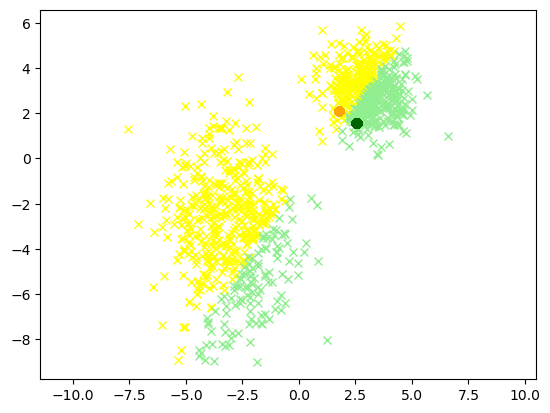

In [15]:
# plot (i) uppon the dataset and also include final clustering of round one

xCluster1 = []
for dataPoint in cluster1:
    xCluster1.append(dataPoint[0])

yCluster1 = []
for dataPoint in cluster1:
    yCluster1.append(dataPoint[1])

xCluster2 = []
for dataPoint in cluster2:
    xCluster2.append(dataPoint[0])

yCluster2 = []
for dataPoint in cluster2:
    yCluster2.append(dataPoint[1])


xR1 = []
for r1 in allValuesOfR1:
    xR1.append(r1[0])

xR2 = []
for r2 in allValuesOfR2:
    xR2.append(r2[0])

yR1 = []
for r1 in allValuesOfR1:
    yR1.append(r1[1])

yR2 = []
for r2 in allValuesOfR2:
    yR2.append(r2[1])

labels=c[2]
plt.plot(xCluster1, yCluster1, "x", color = "yellow") 
plt.plot(xCluster2, yCluster2, "x", color = "lightgreen") 

plt.plot(xR1, yR1, "o", color = "orange")
plt.plot(xR2, yR2, "o", color = "darkgreen")

plt.axis("equal") 
plt .show()

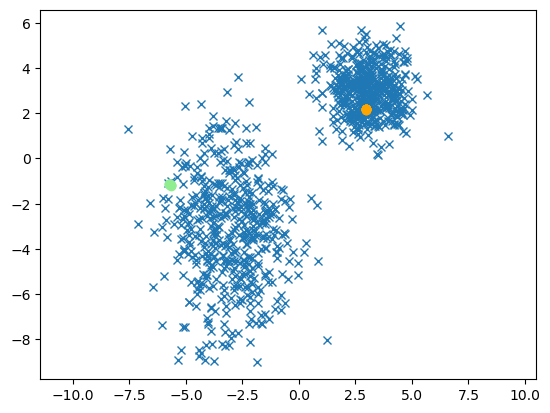

In [16]:
# plot (ii) uppon the dataset

x = c[0] 
y=c[1]

xR1 = []
for r1 in r1AfterClustering:
    xR1.append(r1[0])

xR2 = []
for r2 in r2AfterClustering:
    xR2.append(r2[0])

yR1 = []
for r1 in r1AfterClustering:
    yR1.append(r1[1])

yR2 = []
for r2 in r2AfterClustering:
    yR2.append(r2[1])
    
labels=c[2]
plt.plot(x, y, "x") 
plt.plot(xR1, yR1, "o", color = "orange")
plt.plot(xR2, yR2, "o", color = "lightgreen")

plt.axis("equal") 
plt .show()

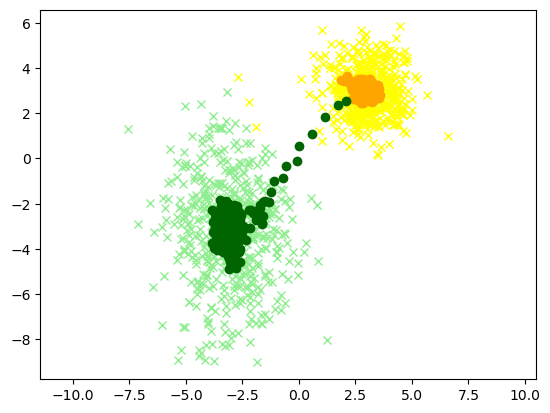

In [17]:
# define parameters, try DIFFERENT ALPHA
alpha = 0.1

# choose random k indexes
# copy data for immutability and transpose to sample complete case
cTCopy = c.T
idexOfPoint1, indexOfPoint2= random.sample(range(len(cTCopy)), k=2)

# define the two k points following the andom indexes
r1 = cTCopy[idexOfPoint1][:2]
r2 = cTCopy[indexOfPoint2][:2]

# initialize two np.arrays to save clusters
cluster1 = []
cluster2 = []

# save all consecutive values of r1 and r2 for the first passage
allValuesOfR1 = []
allValuesOfR2 = []

# implement easy k-means version
for i in range(len(cTCopy)):
    # divide every point in coordinates and label
    coordinate = cTCopy[i][:2]
    trueClusterLabel = cTCopy[i][2]

    # get distance to both k
    distanceToR1 = getEuclideanDistance(r1[0],r1[1], coordinate[0], coordinate[1])
    distanceToR2 = getEuclideanDistance(r2[0],r2[1], coordinate[0], coordinate[1])

    

    # append to cluster of k to which point is closer, swiftly adjust k in position
    if distanceToR1 < distanceToR2:
        allValuesOfR1.append(r1)
        cluster1.append([*coordinate, trueClusterLabel])
        r1 = (1-alpha)*r1+alpha*coordinate
    else:
        allValuesOfR2.append(r2)
        cluster2.append([*coordinate, trueClusterLabel])
        r2 = (1-alpha)*r2+alpha*coordinate

# plot (i) uppon the dataset and also include final clustering of round one

xCluster1 = []
for dataPoint in cluster1:
    xCluster1.append(dataPoint[0])

yCluster1 = []
for dataPoint in cluster1:
    yCluster1.append(dataPoint[1])

xCluster2 = []
for dataPoint in cluster2:
    xCluster2.append(dataPoint[0])

yCluster2 = []
for dataPoint in cluster2:
    yCluster2.append(dataPoint[1])


xR1 = []
for r1 in allValuesOfR1:
    xR1.append(r1[0])

xR2 = []
for r2 in allValuesOfR2:
    xR2.append(r2[0])

yR1 = []
for r1 in allValuesOfR1:
    yR1.append(r1[1])

yR2 = []
for r2 in allValuesOfR2:
    yR2.append(r2[1])

labels=c[2]
plt.plot(xCluster1, yCluster1, "x", color = "yellow") 
plt.plot(xCluster2, yCluster2, "x", color = "lightgreen") 

plt.plot(xR1, yR1, "o", color = "orange")
plt.plot(xR2, yR2, "o", color = "darkgreen")

plt.axis("equal") 
plt .show()


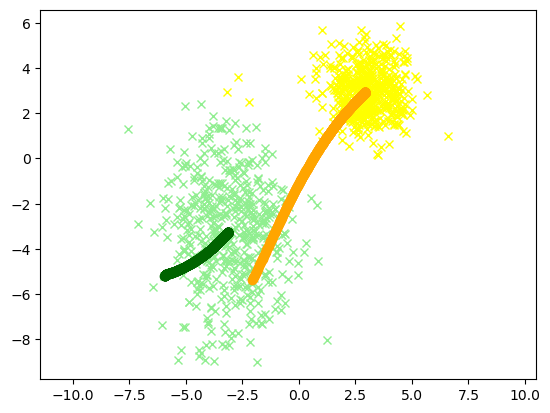

In [18]:
# (ii) the values of r1 and r2 at the end of each passage. Try DIFFERENT NUMBER OF EPOCHS

# define parameters
alpha = 0.00001

# choose random k indexes
# copy data for immutability and transpose to sample complete case
cTCopy = c.T
idexOfPoint1, indexOfPoint2= random.sample(range(len(cTCopy)), k=2)

# define the two k points following the andom indexes
r1 = cTCopy[idexOfPoint1][:2]
r2 = cTCopy[indexOfPoint2][:2]

# initialize two np.arrays to save clusters
cluster1 = []
cluster2 = []

# initialize lists to store final r1 and r2 values
r1AfterClustering = []
r2AfterClustering = []

# repeat for 10 times, EPOCHS:
for i in range(1000):

    # initialize two np.arrays to save final clusters
    cluster1 = []
    cluster2 = []

    # implement easy k-means version
    for i in range(len(cTCopy)):
        # divide every point in coordinates and label
        coordinate = cTCopy[i][:2]
        trueClusterLabel = cTCopy[i][2]

        # get distance to both k
        distanceToR1 = getEuclideanDistance(r1[0],r1[1], coordinate[0], coordinate[1])
        distanceToR2 = getEuclideanDistance(r2[0],r2[1], coordinate[0], coordinate[1])

        # append to cluster of k to which point is closer, swiftly adjust k in position
        if distanceToR1 < distanceToR2:
            cluster1.append([*coordinate, trueClusterLabel])
            r1 = (1-alpha)*r1+alpha*coordinate
        else:
            cluster2.append([*coordinate, trueClusterLabel])
            r2 = (1-alpha)*r2+alpha*coordinate


    r1AfterClustering.append(r1)
    r2AfterClustering.append(r2)

# plot (ii) uppon the dataset

xCluster1 = []
for dataPoint in cluster1:
    xCluster1.append(dataPoint[0])

yCluster1 = []
for dataPoint in cluster1:
    yCluster1.append(dataPoint[1])

xCluster2 = []
for dataPoint in cluster2:
    xCluster2.append(dataPoint[0])

yCluster2 = []
for dataPoint in cluster2:
    yCluster2.append(dataPoint[1])

xR1 = []
for r1 in r1AfterClustering:
    xR1.append(r1[0])

xR2 = []
for r2 in r2AfterClustering:
    xR2.append(r2[0])

yR1 = []
for r1 in r1AfterClustering:
    yR1.append(r1[1])

yR2 = []
for r2 in r2AfterClustering:
    yR2.append(r2[1])
    
labels=c[2]
plt.plot(xCluster1, yCluster1, "x", color = "yellow") 
plt.plot(xCluster2, yCluster2, "x", color = "lightgreen") 
plt.plot(xR1, yR1, "o", color = "orange")
plt.plot(xR2, yR2, "o", color = "darkgreen")

plt.axis("equal") 
plt .show()


#### What effect does changing the parameters alpha and the number of epochs have?

After trying out multiple values of alpha and number of epochs, we can say that in both cases, a higher value leads to more movement of k1 and k2. The clusters adapt and change more and faster. Changing the alpha to a bigger number seems to have a stronger corrective effect that changing the epochs to a higher repetition.


### Exercise 1.4

 Instead of changing the value of the representatives for each example, accumulate the values of the difference (x − r) and change the value only when all examples have been observed. Accumulate only for the closest representative in each iteration.

    for all x do
        d ← d + (x − r)
    end for
        r ← r + (α/n_examples) ∗ d

In [90]:
# define parameters
alpha = 0.00001

# choose random k indexes
# copy data for immutability and transpose to sample complete case
cTCopy = c.T
idexOfPoint1, indexOfPoint2= random.sample(range(len(cTCopy)), k=2)

# define the two k points following the andom indexes
r1 = cTCopy[idexOfPoint1][:2]
r2 = cTCopy[indexOfPoint2][:2]
r1End = None
r2End = None


allR1 = np.array([r1]).reshape(1, -1)
allR2 = np.array([r2]).reshape(1, -1)


# loop mulitple rounds, epochs:
for i in range(100):

    # from the second round on (i.e., when r2End != None) assign r1 and r2 the new values
    if r1End is None:
        pass
    else:
        r1 = r1End

    if r2End is None:
        pass
    else:
        r2 = r2End
    
    # initialize two np.arrays to save clusters
    cluster1 = []
    cluster2 = []

    # save all consecutive values of r1 and r2 for the first passage
    allValuesOfR1 = []
    allValuesOfR2 = []

    # save total distances
    d1 = np.array([0,0])
    d2 = np.array([0,0])

    # implement second k-means version
    for i in range(len(cTCopy)):
        # divide every point in coordinates and label
        coordinate = cTCopy[i][:2]
        trueClusterLabel = cTCopy[i][2]

        # get distance to both k
        distanceToR1 = getEuclideanDistance(r1[0],r1[1], coordinate[0], coordinate[1])
        distanceToR2 = getEuclideanDistance(r2[0],r2[1], coordinate[0], coordinate[1])

        # append to cluster of k to which point is closer
        if distanceToR1 < distanceToR2:
            cluster1.append([*coordinate, trueClusterLabel])
            d1 = d1 +(coordinate - r1)
        else:
            cluster2.append([*coordinate, trueClusterLabel])
            d2 = d2 +(coordinate - r2)
    # only now change coordinates of r1 and r2
    r1End = r1 + (alpha/len(cluster1))*d1
    r2End = r2 + (alpha/len(cluster2))*d2

    # append all new values for k1, k2
    allR1 = np.append(allR1, r1End.reshape(1, -1), axis=0)
    allR2 = np.append(allR2, r2End.reshape(1, -1), axis=0)


# check length of final clusters to see whether all points have been assigned
allR1

array([[4.17277418, 3.18105138],
       [4.17276963, 3.18104825],
       [4.17276508, 3.18104511],
       [4.17276053, 3.18104197],
       [4.17275598, 3.18103884],
       [4.17275143, 3.1810357 ],
       [4.17274688, 3.18103257],
       [4.17274233, 3.18102943],
       [4.17273778, 3.1810263 ],
       [4.17273323, 3.18102316],
       [4.17272868, 3.18102003],
       [4.17272413, 3.18101689],
       [4.17271958, 3.18101375],
       [4.17271503, 3.18101062],
       [4.17271048, 3.18100748],
       [4.17270593, 3.18100435],
       [4.17270138, 3.18100121],
       [4.17269683, 3.18099808],
       [4.17269228, 3.18099494],
       [4.17268774, 3.18099181],
       [4.17268319, 3.18098867],
       [4.17267864, 3.18098554],
       [4.17267409, 3.1809824 ],
       [4.17266954, 3.18097927],
       [4.17266499, 3.18097613],
       [4.17266044, 3.180973  ],
       [4.17265589, 3.18096986],
       [4.17265134, 3.18096673],
       [4.17264679, 3.18096359],
       [4.17264222, 3.18096051],
       [4.


### Exercise 1.5
 Plot the consecutive positions of r1 and r2 and compare with the plot in exercise 1.

What do you observe?

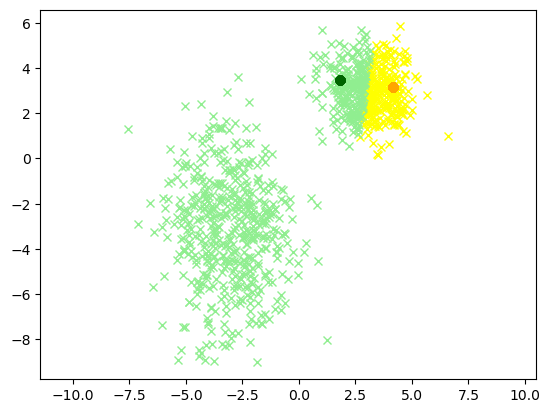

In [91]:
# plot the consecutive positions of r1 and r2 uppon the dataset and also include final clustering of round one

xCluster1 = []
for dataPoint in cluster1:
    xCluster1.append(dataPoint[0])

yCluster1 = []
for dataPoint in cluster1:
    yCluster1.append(dataPoint[1])

xCluster2 = []
for dataPoint in cluster2:
    xCluster2.append(dataPoint[0])

yCluster2 = []
for dataPoint in cluster2:
    yCluster2.append(dataPoint[1])


xR1 = allR1[:, 0]

xR2 = allR2[:, 0]

yR1 = allR1[:, 1]

yR2 = allR2[:, 1]

plt.plot(xCluster1, yCluster1, "x", color = "yellow") 
plt.plot(xCluster2, yCluster2, "x", color = "lightgreen") 

plt.plot(xR1, yR1, "o", color = "orange")
plt.plot(xR2, yR2, "o", color = "darkgreen")

plt.axis("equal") 
plt .show()

### What do you observe?

Again the movement of r1, r2 are dependent on their random first value and the values of alpha and epoche. 
However, the movement of r1, r2 seems to be more targeted and does not randomly jump here and there deoending on which random point was classified just now. If we would set epoche to (move until no change between r1 and r1End and r2 and r2End) the final and mainly correct clustering could be achieved.

### Exercise 1.6

Plot with different colors:

- color 1 – points closer to r1 labeled 1;
- color 2 – points closer to r1 labeled 2; 
- color 3 – points closer to r2 labeled 1; 
- color 4 – points closer to r2 labeled 2.
 
What do you observe?


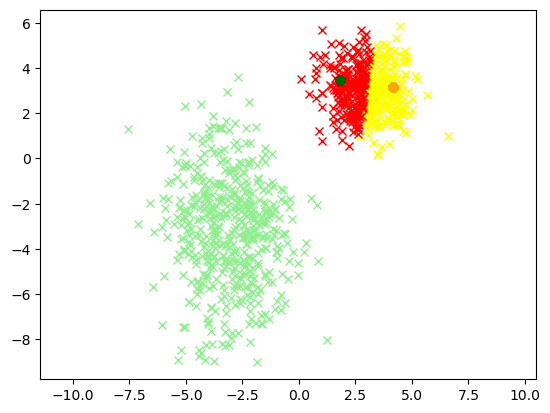

In [92]:
# plot the consecutive positions of r1 and r2 uppon the dataset and also include final clustering of round one

xCluster1Correct = []
xCluster1False = []

for dataPoint in cluster1:
    if dataPoint[2] == 1:
        xCluster1Correct.append(dataPoint[0])
    else: 
        xCluster1False.append(dataPoint[0])

yCluster1Correct = []
yCluster1False = []

for dataPoint in cluster1:
    if dataPoint[2] == 1:
        yCluster1Correct.append(dataPoint[1])
    else: 
        yCluster1False.append(dataPoint[1])



xCluster2Correct = []
xCluster2False = []

for dataPoint in cluster2:
    if dataPoint[2] == 2:
        xCluster2Correct.append(dataPoint[0])
    else: 
        xCluster2False.append(dataPoint[0])

yCluster2Correct = []
yCluster2False = []

for dataPoint in cluster2:
    if dataPoint[2] == 2:
        yCluster2Correct.append(dataPoint[1])
    else: 
        yCluster2False.append(dataPoint[1])



xR1 = allR1[:, 0]

xR2 = allR2[:, 0]

yR1 = allR1[:, 1]

yR2 = allR2[:, 1]

plt.plot(xCluster1Correct, yCluster1Correct, "x", color = "yellow") 
plt.plot(xCluster2Correct, yCluster2Correct, "x", color = "lightgreen") 
plt.plot(xCluster1False, yCluster1False, "x", color = "pink") 
plt.plot(xCluster2False, yCluster2False, "x", color = "red") 

plt.plot(xR1, yR1, "o", color = "orange")
plt.plot(xR2, yR2, "o", color = "darkgreen")

plt.axis("equal") 
plt .show()

#### What do we observe?

- fix ? that the random k points can be from any cluster and then everything is in the wrong colour? Or is that correct?



### Exercise 1.7

Repeat the experiment 30 times and plot the final values of r1 and r2 over the dataset. If necessary amplify the viewed area to see the points’ distributions.

In [ ]:
### not sure, what to do?!?! What should be repeated 30 times? And which state should be visualized?

# Exercise 2

Implement a simplified version of agglomerative hierarchical clustering, as proposed in the following algorithm.

    while there are more than two points do
        Find the closest two points
        Replace both points by their average
    end while

Test it on sets of points similar to the ones of the last exercise.  

In [208]:
dataSetInProgress = data.T[0:20]
dataSetInProgress

array([[-1.49810997,  0.47696045,  2.        ],
       [ 3.99364224,  3.51375516,  1.        ],
       [ 1.3549472 ,  3.23704086,  1.        ],
       [-4.06224853, -2.55959194,  2.        ],
       [-4.49716226, -5.78018835,  2.        ],
       [-5.06685185, -4.09718249,  2.        ],
       [-0.97208963, -6.29277653,  2.        ],
       [-5.06691018, -2.28344603,  2.        ],
       [ 3.79411545,  4.08003563,  1.        ],
       [ 1.78325358,  5.09103125,  1.        ],
       [-1.79788823, -5.67936944,  2.        ],
       [ 3.48915483,  0.13575218,  1.        ],
       [-4.61978986, -1.96700994,  2.        ],
       [-2.60096564, -6.218989  ,  2.        ],
       [-2.08998899, -5.56942517,  2.        ],
       [ 4.64165357,  2.6608759 ,  1.        ],
       [-3.15848108, -1.84704967,  2.        ],
       [-2.15014102, -2.02864282,  2.        ],
       [ 4.24807242,  3.73693885,  1.        ],
       [-3.34195357, -5.57513385,  2.        ]])

In [201]:
np.array((True, False)).all()

arr1 = np.array((1,2,3))
arr2 = np.array((1,3,5))

arr1==arr2

array([ True, False, False])

In [212]:
dataSetInProgress = data.T[0:20]
dictionaryWithDistances = {}


# get all distances between all points
for i in dataSetInProgress:
    for j in dataSetInProgress:
        if not ((i==j).all()):
            distance = getEuclideanDistance(i[0], i[1], j[0], j[1])
            dictionaryWithDistances[(tuple(i), tuple(j))] = distance
print(len(dictionaryWithDistances))

newPointInMIddle = None

while len(dataSetInProgress) > 2:
    if newPointInMIddle is not None:
        for i in dataSetInProgress:
            distance = getEuclideanDistance(i[0], i[1], newPointInMIddle[0][0], newPointInMIddle[0][1])
            dictionaryWithDistances[(tuple(i), tuple(newPointInMIddle[0]))] = distance
    print(len(dictionaryWithDistances))

    pairWithShortestDistance = min(dictionaryWithDistances, key=dictionaryWithDistances.get)

    # calculate midpoint
    newPointInMIddle = np.mean(pairWithShortestDistance, axis = 0)
    newPointInMIddle = np.array([newPointInMIddle])
    #([((pairWithShortestDistance[0][0]+pairWithShortestDistance[1][0])/2), ((pairWithShortestDistance[0][1]+pairWithShortestDistance[1][1])/2),  ((pairWithShortestDistance[0][2]+pairWithShortestDistance[1][2])/2)])

    # delete 2 datapoints that are closest


    index1ofRowToDelete = np.where((dataSetInProgress == np.array(pairWithShortestDistance[0])).all(axis=1))[0]
    print(index1ofRowToDelete)
    dataSetInProgress = np.delete(dataSetInProgress, index1ofRowToDelete, axis=0)

    index2ofRowToDelete = np.where((dataSetInProgress == np.array(pairWithShortestDistance[1])).all(axis=1))[0]
    dataSetInProgress = np.delete(dataSetInProgress, index2ofRowToDelete, axis=0)
    
    # also delete all entries in dictionary where the two points were included
    keysToRemove = []
    point1ToDeleteAsTuple = tuple(pairWithShortestDistance[0])
    point2ToDeleteAsTuple = tuple(pairWithShortestDistance[1])

    for key in list(dictionaryWithDistances):
        if key[0] == point1ToDeleteAsTuple or key[0] == point2ToDeleteAsTuple or key[1] == point1ToDeleteAsTuple or key[1] == point2ToDeleteAsTuple:
            keysToRemove.append(key)
    for key in keysToRemove:
        dictionaryWithDistances.pop(key, None)

    len(dictionaryWithDistances)

    # add new midpoint
    dataSetInProgress = np.concatenate((dataSetInProgress, newPointInMIddle), axis = 0)
    print(len(dataSetInProgress))

380
380
[10]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19
325
[18]
19


KeyboardInterrupt: 

In [20]:
class KMeansClustering:

    # attributes
    k = None
    setWithDataTuples = None
    kDataPoinsInSet = None
    dictWithMappingAllPointsToK = None
    newKPointsinSet = None
    clusterCentroids = None
    clusterMemberships = None
    colourMap = None
    listOfColours = ["black", "green", "orange", "darkred", "darkblue", "lightblue", "purple", "pink", "cyan", "olive", "gray", "lightpink"]


    # constructor
    def __init__(self, setWithDataTuples, k):
        self.setWithDataTuples = setWithDataTuples
        self.k = k
        
    def __str__(self):
        return "K-Means Clustering Object" 
    


    # define all helper methods

    def __defineRandomKStart(self):
        # initiate list to store k random points
        kDataPointsInSet = set()
        # randomly draw k numbers in the rande of how long listWithDataTuples is
        rng = np.random.default_rng()
        randomPositionsOfKPoints = rng.integers(low=0, high=len(self.setWithDataTuples), size=self.k)
        # chose k points as random start points
        for i in randomPositionsOfKPoints:
            kDataPointsInSet.add(self.setWithDataTuples[i])
        
        # map colours to initial k points
        colourMap = {}
        number = 0
        for i in kDataPointsInSet:
            number += 1
            colourMap[i] = self.listOfColours[number]
        self.colourMap = colourMap
        
        return(kDataPointsInSet)
    


    def __mapAllPointsToNearestK(self, setOfKs):
        # calculate distance from each point to all k points
        dictWithMappingAllPointsToK = {}
        for k in setOfKs:
            dictWithMappingAllPointsToK[k] = []

        for i in self.setWithDataTuples:
            allDistancesFromOnePointToAllK = {}
            for l in setOfKs:
                allDistancesFromOnePointToAllK[l] = (self.__getEuclideanDistance(i[0], i[1], l[0], l[1]))
            # assign each point to the k-point which is closest
            # für minimales k:
            minK = min(allDistancesFromOnePointToAllK, key=allDistancesFromOnePointToAllK.get)
            dictWithMappingAllPointsToK[minK].append(i)

        return(dictWithMappingAllPointsToK)



    def __calcKNewMeans(self, dictWithMappingAllPointsToK):
        newKPointsinSet = set()
        for listWithPoints in dictWithMappingAllPointsToK.values():
            newMeanXCoordinate = []
            newMeanYCoordinate = []
            for i in range(len(listWithPoints)):
                newMeanXCoordinate.append(listWithPoints[i][0])
                newMeanX = round(sum(newMeanXCoordinate)/len(newMeanXCoordinate), 6)
                newMeanYCoordinate.append(listWithPoints[i][1])
                newMeanY = round(sum(newMeanYCoordinate)/len(newMeanYCoordinate), 6)
            newKPointsinSet.add((newMeanX, newMeanY,))

        # map colours to new centroids (that are closest to old ones)
        self.__reassignColorsToCentroids(newKPointsinSet)
            
        
        return(newKPointsinSet)
    

    def __reassignColorsToCentroids(self, newCentroids):
        # Dictionary to store the updated color mapping
        newColorMapping = {}
        
        # Find closest new centroid for each old centroid and assign the same color
        usedNewCentroids = set()
        for oldCentroid in self.colourMap:
            closestNewCentroid = min(newCentroids, key=lambda newCentroid: self.__getEuclideanDistance(oldCentroid[0], oldCentroid[1], newCentroid[0], newCentroid[1]))
            newColorMapping[closestNewCentroid] = self.colourMap[oldCentroid]
            usedNewCentroids.add(closestNewCentroid)
        
        # Find remaining colors from old centroids (i.e., those not reused)
        remainingColors = set(self.colourMap.values()) - set(newColorMapping.values())
        
        # Find new centroids that haven't been assigned a color yet
        unusedNewCentroids = set(newCentroids) - usedNewCentroids
        
        # Assign remaining colors from old centroids to new centroids
        for newCentroid in unusedNewCentroids:
            if remainingColors:
                newColorMapping[newCentroid] = remainingColors.pop()
            else:
                # Fallback if no remaining colors (this shouldn't happen with enough colors)
                newColorMapping[newCentroid] = "gray"
        
        # Update the color mapping to the new centroids
        self.colourMap = newColorMapping
    





    # main functions

    def cluster(self):

        # arbitrarily choose k objects from D as the initial cluster centres
        kDataPointsInSet = self.__defineRandomKStart()

        # assign each object to the cluster to which the object is most similar and update cluster means until no change
        mappingOld = 1
        mappingEnd = 0
        while mappingOld != mappingEnd:
            mappingOld = self.__mapAllPointsToNearestK(kDataPointsInSet)
            kDataPointsInSet = self.__calcKNewMeans(mappingOld)
            mappingEnd = self.__mapAllPointsToNearestK(kDataPointsInSet)

            self.clusterCentroids = kDataPointsInSet
            self.clusterMemberships = mappingEnd
            self.visualize()

        return(kDataPointsInSet, mappingEnd)
    

    def visualize(self):

        listWithListsX = []
        listWithListsY = []

        for centroid in self.clusterCentroids:
            oneListWithX = []
            oneListWithY = []
            for x in self.clusterMemberships[centroid]:
                oneListWithX.append(x[0])
            for y in self.clusterMemberships[centroid]:
                oneListWithY.append(y[1])
            listWithListsX.append(oneListWithX)
            listWithListsY.append(oneListWithY)
        

        for i in range(len(listWithListsX)):   
            centroid = list(self.clusterCentroids)[i] 
            plt.plot(listWithListsX[i], listWithListsY[i], "o", color=self.colourMap[centroid])
        plt.show()



    # helper function: calculate euclidean distance with 2 coordinates of the train and two coordinates of the test data 
    ### todo: can I generalize the function to take in any input coordinate length?!
    @staticmethod
    def __getEuclideanDistance(trainData1Coordinate, trainData2Coordinate, testData1Coordinate, testData2Coordinate):
        distance = math.sqrt((trainData1Coordinate-testData1Coordinate)**2+(trainData2Coordinate-testData2Coordinate)**2)
        return(distance)
    

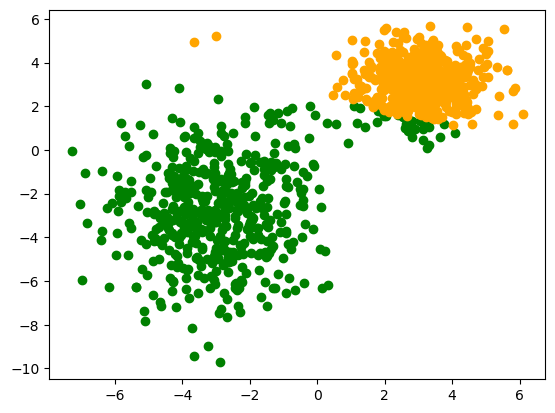

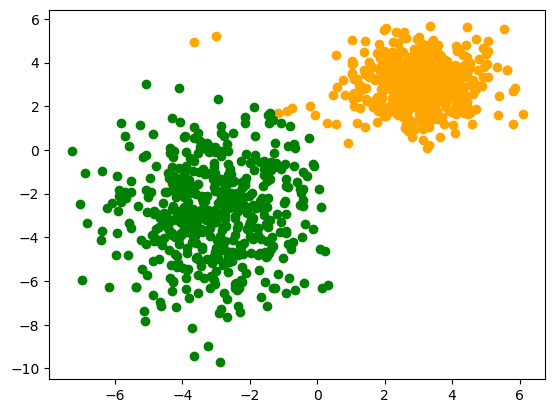

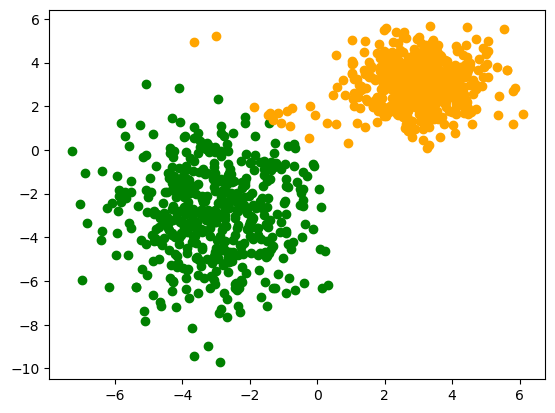

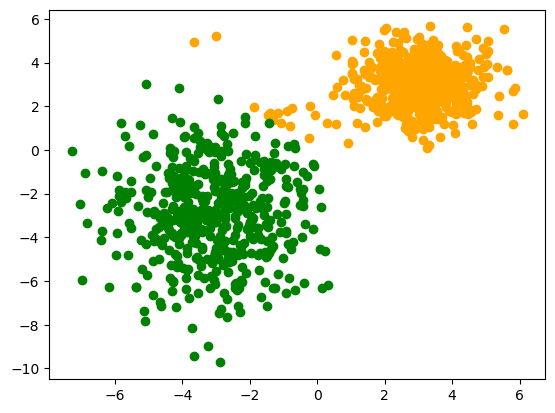

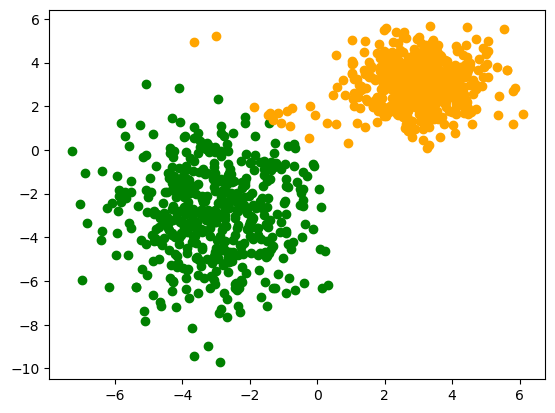

({(-3.095757, -2.9876), (2.91355, 3.005815)},
 {(-3.095757, -2.9876): [(-5.967993669028344, -4.815962205891925),
   (-4.193387602909823, -7.178835383671863),
   (-2.267863605692491, -0.4878615428160513),
   (-1.584053874522999, -0.879493602188882),
   (-2.427804081229976, -3.1141983969649667),
   (-4.016174239995958, -3.264243147031859),
   (-0.45162587615097705, -3.9695842186935755),
   (-4.059001409093602, -1.4920942044113772),
   (-2.364357198367339, -3.4359735492455714),
   (-3.4074050846286115, -4.535029475793432),
   (-2.8156493124673068, -1.8600201969967178),
   (-3.0938594809796114, -1.3170911665793854),
   (-0.41020281923224866, -2.586429588691072),
   (-4.148861427031306, -4.8671738234832755),
   (-3.808690144095187, -1.3619096809560238),
   (-2.3834792588796265, -6.392083304775262),
   (-3.7791043065503365, -3.35228596222084),
   (-2.62166634028758, -2.6582253292129394),
   (-3.8664110669936367, -4.727577202204838),
   (-3.584743493141909, -2.0165271026818488),
   (-2.347453

In [32]:
xy_tuples = list(zip(c[0], c[1]))
newModel = KMeansClustering(xy_tuples, 2)
newModel.cluster()

# Exercise 3

Implement the DBScan algorithm as described in https://www.youtube.com/watch?v=_A9Tq6mGtLI 
and demonstrate graphically the process with a series of snapshots of the process at key points with adequate descriptions.


In [ ]:
# test with having added more distributions (clusters)